<a href="https://colab.research.google.com/github/nvp951753/MangoImageSegmentation/blob/main/imagesegment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow.keras.utils as u
import glob
import random
import cv2
from random import shuffle
import random
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!unzip /content/drive/MyDrive/dataset/xoai.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: dttrain/39320.jpg       
  inflating: dttrain/39321.jpg       
  inflating: dttrain/39330.jpg       
  inflating: dttrain/39331.jpg       
  inflating: dttrain/39340.jpg       
  inflating: dttrain/39341.jpg       
  inflating: dttrain/39350.jpg       
  inflating: dttrain/39351.jpg       
  inflating: dttrain/39360.jpg       
  inflating: dttrain/39361.jpg       
  inflating: dttrain/39370.jpg       
  inflating: dttrain/39371.jpg       
  inflating: dttrain/39380.jpg       
  inflating: dttrain/39381.jpg       
  inflating: dttrain/39390.jpg       
  inflating: dttrain/39391.jpg       
  inflating: dttrain/3940.jpg        
  inflating: dttrain/39400.jpg       
  inflating: dttrain/39401.jpg       
  inflating: dttrain/3941.jpg        
  inflating: dttrain/39410.jpg       
  inflating: dttrain/39411.jpg       
  inflating: dttrain/39420.jpg       
  inflating: dttrain/39421.jpg       
  inflating: dttrain/39430.jpg 

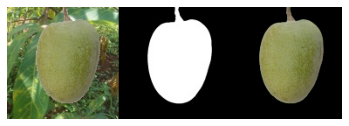

In [ ]:
count = 0
x_train = []
y_train = []
link = 'dttrain/'+str(count)+str(0)+'.jpg'
img = cv2.imread(link)
linkm = 'dttrain/'+str(count)+str(1)+'.jpg'
mask=cv2.imread(linkm)
while (type(img)!=type(None)):
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x_train.append(img)
  y_train.append(mask)
  count+=1
  link = 'dttrain/'+str(count)+str(0)+'.jpg'
  img = cv2.imread(link)
  linkm = 'dttrain/'+str(count)+str(1)+'.jpg'
  mask=cv2.imread(linkm)
  
x_train= np.array(x_train).astype('float32')
x_train/=255
y_train= np.array(y_train).astype('float32')
y_train/=255
y_train = y_train.reshape(len(y_train),128,128,1)
plt.axis('off')
img = x_train[20]
msk = y_train[20].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [ ]:
y_train.shape

(4400, 128, 128, 1)

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou
def unet(sz = (128, 128, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [ ]:
learning_rate = 1
min_learning_rate = 0.00001 
learning_rate_reduction_factor = 0.5 
learning_rate *= learning_rate_reduction_factor
patience = 3 
verbose = 1 
save_model = ModelCheckpoint(filepath="model.h5", monitor='loss',verbose=verbose,save_best_only=True ,save_weights_only=False , mode='min',save_freq='epoch')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=patience , verbose=verbose ,factor=learning_rate_reduction_factor,min_lr=min_learning_rate)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(4400, 128, 128, 3)
(4400, 128, 128, 1)


In [ ]:
batch_size = 32
history = model.fit(x_train,y_train,epochs=10,batch_size=32,verbose=verbose,validation_split=0.1,callbacks=[
learning_rate_reduction , save_model])

Epoch 1/10
162/162 [==============================] - ETA: 0s - loss: 0.2875 - mean_iou: 0.5612
Epoch 1: loss improved from inf to 0.28749, saving model to model.h5
162/162 [==============================] - 33s 85ms/step - loss: 0.2875 - mean_iou: 0.5612 - val_loss: 0.0814 - val_mean_iou: 0.6899 - lr: 0.0010
Epoch 2/10
162/162 [==============================] - ETA: 0s - loss: 0.1218 - mean_iou: 0.7206
Epoch 2: loss improved from 0.28749 to 0.12180, saving model to model.h5
162/162 [==============================] - 13s 82ms/step - loss: 0.1218 - mean_iou: 0.7206 - val_loss: 0.0590 - val_mean_iou: 0.7015 - lr: 0.0010
Epoch 3/10
162/162 [==============================] - ETA: 0s - loss: 0.0847 - mean_iou: 0.7424
Epoch 3: loss improved from 0.12180 to 0.08474, saving model to model.h5
162/162 [==============================] - 13s 82ms/step - loss: 0.0847 - mean_iou: 0.7424 - val_loss: 0.0717 - val_mean_iou: 0.6983 - lr: 0.0010
Epoch 4/10
162/162 [==============================] - ETA: 

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 8)    0           ['conv2d_1[0][0]']           

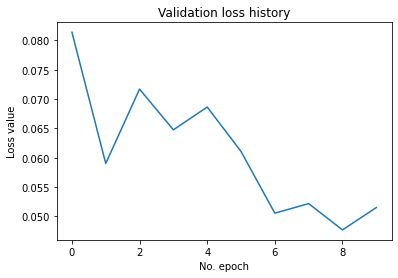

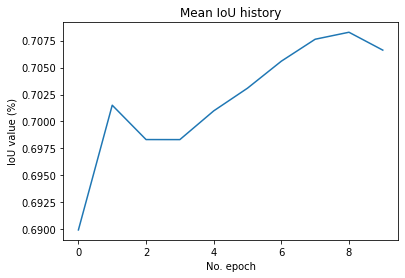

In [ ]:
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_mean_iou'])
plt.title('Mean IoU history')
plt.ylabel('IoU value (%)')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
def correction(
        img,
        shadow_amount_percent, shadow_tone_percent, shadow_radius,
        highlight_amount_percent, highlight_tone_percent, highlight_radius,
        color_percent
):
    """
    Image Shadow / Highlight Correction. The same function as it in Photoshop / GIMP
    :param img: input RGB image numpy array of shape (height, width, 3)
    :param shadow_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param shadow_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param shadow_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param highlight_amount_percent [0.0 ~ 1.0]: Controls (separately for the highlight and shadow values in the image) how much of a correction to make.
    :param highlight_tone_percent [0.0 ~ 1.0]: Controls the range of tones in the shadows or highlights that are modified.
    :param highlight_radius [>0]: Controls the size of the local neighborhood around each pixel
    :param color_percent [-1.0 ~ 1.0]:
    :return:
    """
    shadow_tone = shadow_tone_percent * 255
    highlight_tone = 255 - highlight_tone_percent * 255

    shadow_gain = 1 + shadow_amount_percent * 6
    highlight_gain = 1 + highlight_amount_percent * 6

    # extract RGB channel
    height, width = img.shape[:2]
    img = img.astype(np.float)
    img_R, img_G, img_B = img[..., 2].reshape(-1), img[..., 1].reshape(-1), img[..., 0].reshape(-1)

    # The entire correction process is carried out in YUV space,
    # adjust highlights/shadows in Y space, and adjust colors in UV space
    # convert to Y channel (grey intensity) and UV channel (color)
    img_Y = .3 * img_R + .59 * img_G + .11 * img_B
    img_U = -img_R * .168736 - img_G * .331264 + img_B * .5
    img_V = img_R * .5 - img_G * .418688 - img_B * .081312

    # extract shadow / highlight
    shadow_map = 255 - img_Y * 255 / shadow_tone
    shadow_map[np.where(img_Y >= shadow_tone)] = 0
    highlight_map = 255 - (255 - img_Y) * 255 / (255 - highlight_tone)
    highlight_map[np.where(img_Y <= highlight_tone)] = 0

    # // Gaussian blur on tone map, for smoother transition
    if shadow_amount_percent * shadow_radius > 0:
        # shadow_map = cv2.GaussianBlur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius), sigmaX=0).reshape(-1)
        shadow_map = cv2.blur(shadow_map.reshape(height, width), ksize=(shadow_radius, shadow_radius), borderType = cv2.BORDER_DEFAULT)
        shadow_map = shadow_map.reshape(-1)

    if highlight_amount_percent * highlight_radius > 0:
        # highlight_map = cv2.GaussianBlur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius), sigmaX=0).reshape(-1)
        highlight_map = cv2.blur(highlight_map.reshape(height, width), ksize=(highlight_radius, highlight_radius),borderType = cv2.BORDER_DEFAULT)
        highlight_map = highlight_map.reshape(-1)
    # Tone LUT
    t = np.arange(256)
    LUT_shadow = (1 - np.power(1 - t * (1 / 255), shadow_gain)) * 255
    LUT_shadow = np.maximum(0, np.minimum(255, np.int_(LUT_shadow + .5)))
    LUT_highlight = np.power(t * (1 / 255), highlight_gain) * 255
    LUT_highlight = np.maximum(0, np.minimum(255, np.int_(LUT_highlight + .5)))

    # adjust tone
    shadow_map = shadow_map * (1 / 255)
    highlight_map = highlight_map * (1 / 255)

    iH = (1 - shadow_map) * img_Y + shadow_map * LUT_shadow[np.int_(img_Y)]
    iH = (1 - highlight_map) * iH + highlight_map * LUT_highlight[np.int_(iH)]
    img_Y = iH

    # adjust color
    if color_percent != 0:
        # color LUT
        if color_percent > 0:
            LUT = (1 - np.sqrt(np.arange(32768)) * (1 / 128)) * color_percent + 1
        else:
            LUT = np.sqrt(np.arange(32768)) * (1 / 128) * color_percent + 1

        # adjust color saturation adaptively according to highlights/shadows
        color_gain = LUT[np.int_(img_U ** 2 + img_V ** 2 + .5)]
        w = 1 - np.minimum(2 - (shadow_map + highlight_map), 1)
        img_U = w * img_U + (1 - w) * img_U * color_gain
        img_V = w * img_V + (1 - w) * img_V * color_gain

    # re convert to RGB channel
    output_R = np.int_(img_Y + 1.402 * img_V + .5)
    output_G = np.int_(img_Y - .34414 * img_U - .71414 * img_V + .5)
    output_B = np.int_(img_Y + 1.772 * img_U + .5)

    output = np.row_stack([output_B, output_G, output_R]).T.reshape(height, width, 3)
    output = np.minimum(output, 255).astype(np.uint8)
    return output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


5.770117062536301
195


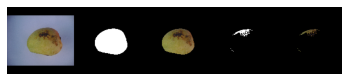

In [ ]:
from tensorflow.python.platform.tf_logging import error
def make_square(img):
    '''
    Reshapes the non-square image by pasting
    it to the centre of a black canvas of size
    n*n where n is the biggest dimension of
    the non-square image. 
    '''
    #Getting the bigger side of the image
    s = max(img.shape[0:2])

    #Creating a dark square with NUMPY  
    f = np.zeros((s,s,3),np.uint8)

    #Getting the centering position
    ax,ay = (s - img.shape[1])//2,(s - img.shape[0])//2

    #Pasting the 'image' in a centering position
    f[ay:img.shape[0]+ay,ax:ax+img.shape[1]] = img
    return f
    
tenfile = 'm (49).JPG'
pre = Image.open(tenfile)
pre= np.array(pre)
pre = make_square(pre)
pre = cv2.resize(pre, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
tam=correction(pre,1.,1.,0,0.,1.,0,0)
tam=correction(tam,1.,1.,0,0.,1.,0,0)
tam = cv2.cvtColor(tam, cv2.COLOR_RGB2HSV)
tam = cv2.fastNlMeansDenoisingColored(tam,None,15,10,7,21)
pre = pre.astype('float32')
pre /=255


tam = tam.astype('float32')
tam /=255
#predict the mask 
pred = model.predict(np.expand_dims(pre, 0))

#mask post-processing 
hangsobien=6
msk  = pred.squeeze()
msk = cv2.copyMakeBorder(msk, hangsobien, hangsobien, hangsobien, hangsobien, cv2.BORDER_CONSTANT,value=[0,0,0])
msk = cv2.resize(msk, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 
M,N,k = msk.shape
sum=0.0
count=0
hesoh=0
hesos=3
hesov=6
hesotb=1.1
for i in range(0,M):
  for j in range(0,N):
    if (msk[i,j,0]==1):
      sum+=tam[i,j,0]*hesoh+tam[i,j,1]*hesos+tam[i,j,2]*hesov
      count+=1
avg=sum/count/hesotb
print(avg)
ermsk=np.zeros((128,128,3),np.uint8)
tinh = 0
for i in range(0,M):
  for j in range(0,N):
    
    if ((msk[i,j,0]>0.8) & (tam[i,j,0]*hesoh+tam[i,j,1]*hesos+tam[i,j,2]*hesov<avg)):
      tinh+=1
      ermsk[i,j,0]=1
      ermsk[i,j,1]=1
      ermsk[i,j,2]=1
#show the mask and the segmented image 
print(tinh)
combined = np.concatenate([pre, msk, pre* msk,ermsk, pre*ermsk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

In [ ]:
model = keras.models.load_model('model.h5')

ValueError: ignored